# Introdução

Neste notebook, criarei um modelo de rede neural capaz de classificar as imagens do dataset [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets) em cão ou gato. 

Utilizarei, majoritariamente, a biblioteca tensorflow+keras.

In [1]:
# importacao de bibliotecas necessarias

# bibliotecas de redes neurais
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

# bibliotecas de manipulacao de variaveis de ambiente e acesso a diretorios
import os, warnings
import glob

# bibliotecas de manipulacao e visualizacao de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leitura do Dataset

Optei por realizar a leitura local do dataset em vez do uso de tensorflow_datasets.load() pois essa biblioteca estava gerando um erro em minha máquina.

In [2]:
dir_name='dataset/images/*' # define a pasta onde estao as imagens

pets_files = glob.glob(dir_name)  # cria uma lista com o caminho dos arquivos encontrados dentro da pasta
pets_df = pd.DataFrame(pets_files) # transforma a lista em dataframe

In [3]:
pets_df.columns = ['full_path'] # renomeia a unica coluna do dataframe
pets_df['file_name'] = pets_df['full_path'].str.split('\\').str[1] # cria uma coluna chamada 'file_name' 
# composta pelo nome dos arquivos

Neste dataframe, conforme a documentação, arquivos que começam com letra maiúscula são imagens de gatos, enquanto arquivos que começam com letra minúscula são imagens de cachorros.

Vamos, então, mapear o nome dos arquivos para definir as classes.

In [4]:
pets_df['label'] = pets_df['file_name'].str[0].str.isupper().map({True:'1', False:'0'}) # mapeia arquivo
# com primeira letra maiuscula -> True = 1 = Gato, False = 0 = Cachorro

In [5]:
pets_df.sample(5)

,full_path,file_name,label
5524,dataset/images\Russian_Blue_236.jpg,Russian_Blue_236.jpg,1
2612,dataset/images\english_setter_107.jpg,english_setter_107.jpg,0
1254,dataset/images\Birman_145.jpg,Birman_145.jpg,1
5553,dataset/images\Russian_Blue_48.jpg,Russian_Blue_48.jpg,1
2249,dataset/images\Egyptian_Mau_142.jpg,Egyptian_Mau_142.jpg,1


In [6]:
datagen = image.ImageDataGenerator(rescale=1/255., validation_split=0.2)
# como vamos trabalhar com as cores das imagens, torna-se necessario normalizar os valores do canal RGB para 0 a 1, por isso
# o argumento rescale=1/255
# utilizaremos 20% do dataset como validacao, e os outros 80% como treino.
# essa divisao de treino/validacao se deu experimentalmente. Apos testar com valores superiores e percerber que o modela
# acabava resultando em underfitting

train_generator = datagen.flow_from_dataframe(dataframe=pets_df.sample(pets_df.shape[0]), 
                                              directory= 'dataset/images',
                                              x_col='file_name',
                                              y_col='label',
                                              target_size=(256,256), # retransformamos as imagens em 256x256pixels
                                              class_mode='binary', # nossa classe é 0 ou 1, logo, binario.
                                              shuffle=False,
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(dataframe=pets_df.sample(pets_df.shape[0]), 
                                                   directory= 'dataset/images',
                                                   x_col='file_name',
                                                   y_col='label',
                                                   target_size=(256,256), # retransformamos as imagens em 256x256pixels
                                                   class_mode='binary', # nossa classe é 0 ou 1, logo, binario.
                                                   shuffle=False,
                                                   subset='validation')

C:\Users\Ferrazzo\anaconda3\envs\tensorflorw\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 5912 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.


C:\Users\Ferrazzo\anaconda3\envs\tensorflorw\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# nao encontrei metodo para imprimir os arquivos que causam 
# "UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored."
# e, caso eu use validate_filenames=False, o modelo nao compila devido a esses arquivos com erro.
# como a quantidade é baixa (6 contra 7390 validos), considerei irrelevante.

In [7]:
ones_to_zeros_ratio_train = train_generator.__dict__['classes'].count(1)/len(train_generator.__dict__['classes'])
print(f"Nossa distribuição de classes é de {ones_to_zeros_ratio_train * 100:.4}% no dataset de treino")

ones_to_zeros_ratio_validation = validation_generator.__dict__['classes'].count(1)/len(validation_generator.__dict__['classes'])
print(f"Nossa distribuição de classes é de {ones_to_zeros_ratio_validation * 100:.4}% no dataset de validação")

Nossa distribuição de classes é de 32.93% no dataset de treino
Nossa distribuição de classes é de 32.41% no dataset de validação


Isso implica que nosso dataset está desbalanceado. Pois, de todas imagens de gatos e cachorros, apenas ~32% são imagens de gatos.

Podemos, imaginar, então, que nosso modelo será melhor em predizer imagens de cachorros do que de gatos, pois teve uma carga de treino (e validação) maior em imagens de cachorros.

# Modelo

In [8]:
# durante algumas execucoes, o modelo acabava estabilizando em uma acuracia nao ideal. 
# optei, entao, em deixar uma chamada para reduzir o Learning Rate (LR) atraves do metodo ReduceLROnPlateau
# que reduz o LR quando alguma metrica do modelo estabiliza

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', # qual metrica sera monitorada
                              factor=0.2, # fator de multiplicacao (no caso reducao) do learning rate
                              patience=5, # quantas epocas esperamos o "plateau"
                              min_lr=0.001 # menor learning rate possivel
                                )

In [9]:
model =  keras.Sequential([
    keras.layers.Conv2D(32,5,5, padding='same', activation='relu'), # utilizamos a camada Conv2D para realçar curvas e 
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'), # a camada MaxPooling2D dá mais contraste a esses realces
    keras.layers.Dropout(0.2), # Dropout zera uma parte dos inputs para reduzir a interconectividade dos neuronios
    keras.layers.Flatten(), # reduz os neuronios à uma dimensao
    keras.layers.Dense(32, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02) 
# iniciamos com 0.02 de LR, e reduziremos com ReduceLROnPlateau caso necessario

model.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=['accuracy'])

model_performance = model.fit(train_generator, 
                              validation_data= validation_generator, 
                              callbacks=[reduce_lr], 
                              epochs=80)
# em minhas primeiras execucoes, comecei com 10 epocas, até encontrar um modelo que nao estagnasse em uma baixa acurácia
# logo cedo. Em seguida, avancei para 30 epocas para verificar se as alteracoes de parametros que eu estava executando
# estavam causando efeito em epocas mais a frente. Apos, executei com 50 epocas, onde foi possivel verificar que o modelo
# alcancou uma boa acuracia, mas com espaco para melhoras em proximas epocas. Por fim, executei 80 epocas.
# Nessa execucacao final, pude notar que o modelo estabilizou em uma acuracia razoavel e que mais epocas nao trariam
# muita melhora ao treinamento.


Epoch 1/80
185/185 [==============================] - 45s 231ms/step - loss: 0.6282 - accuracy: 0.6680 - val_loss: 0.6040 - val_accuracy: 0.6759
Epoch 2/80
185/185 [==============================] - 40s 217ms/step - loss: 0.6130 - accuracy: 0.6708 - val_loss: 0.5933 - val_accuracy: 0.6759
Epoch 3/80
185/185 [==============================] - 39s 209ms/step - loss: 0.6001 - accuracy: 0.6756 - val_loss: 0.5960 - val_accuracy: 0.6806
Epoch 4/80
185/185 [==============================] - 37s 203ms/step - loss: 0.5949 - accuracy: 0.6786 - val_loss: 0.5844 - val_accuracy: 0.6888
Epoch 5/80
185/185 [==============================] - 37s 202ms/step - loss: 0.5821 - accuracy: 0.6859 - val_loss: 0.5712 - val_accuracy: 0.7016
Epoch 6/80
185/185 [==============================] - 37s 201ms/step - loss: 0.5722 - accuracy: 0.6947 - val_loss: 0.5756 - val_accuracy: 0.7368
Epoch 7/80
185/185 [==============================] - 38s 206ms/step - loss: 0.5567 - accuracy: 0.7047 - val_loss: 0.5530 - val_ac

185/185 [==============================] - 51s 275ms/step - loss: 0.0494 - accuracy: 0.9893 - val_loss: 0.2158 - val_accuracy: 0.9418
Epoch 58/80
185/185 [==============================] - 51s 273ms/step - loss: 0.0495 - accuracy: 0.9888 - val_loss: 0.2167 - val_accuracy: 0.9405
Epoch 59/80
185/185 [==============================] - 52s 280ms/step - loss: 0.0506 - accuracy: 0.9905 - val_loss: 0.2171 - val_accuracy: 0.9405
Epoch 60/80
185/185 [==============================] - 49s 263ms/step - loss: 0.0503 - accuracy: 0.9909 - val_loss: 0.2161 - val_accuracy: 0.9425
Epoch 61/80
185/185 [==============================] - 37s 199ms/step - loss: 0.0489 - accuracy: 0.9907 - val_loss: 0.2154 - val_accuracy: 0.9418
Epoch 62/80
185/185 [==============================] - 37s 198ms/step - loss: 0.0512 - accuracy: 0.9902 - val_loss: 0.2176 - val_accuracy: 0.9418
Epoch 63/80
185/185 [==============================] - 37s 197ms/step - loss: 0.0490 - accuracy: 0.9905 - val_loss: 0.2161 - val_accurac

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, None, None, 32)    0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                692256    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 694,721
Trainable params: 694,721
Non-trainable params: 0
__________________________________________________

In [11]:
folder = 'models/94_val_acc_01_02_22'
model.save(folder)
pd.DataFrame.from_dict(model_performance.history).to_csv(folder + '/history.csv',index=False)

# salvando o historico de metricas e o modelo para a pasta 'models' para que possamos carrega-los em outras oportunidades

INFO:tensorflow:Assets written to: models/94_val_acc_01_02_22\assets


# Análise das métricas

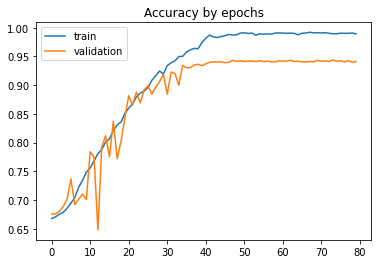

In [13]:
# Plot da acuracia de treino e validacao
plt.plot(model_performance.history['accuracy'])
plt.plot(model_performance.history['val_accuracy'])
plt.title('Accuracy by epochs')
plt.legend(['train', 'validation'])

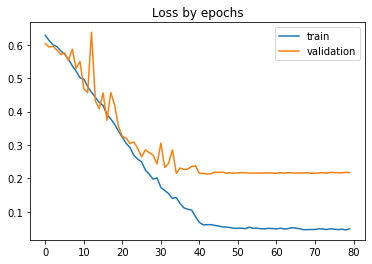

In [19]:
# Plot da perda de treino e validacao
plt.plot(model_performance.history['loss'])
plt.plot(model_performance.history['val_loss'])
plt.title('Loss by epochs')
plt.legend(['train', 'validation'])

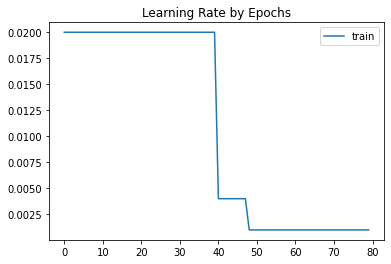

In [20]:
# Plot da variacao do Learning Rate
plt.plot(model_performance.history['lr'])
plt.title('Learning Rate by Epochs')
plt.legend(['train'])

In [21]:
# matriz de confusao
train_pred = model.predict(validation_generator)
confus_matrix = tf.math.confusion_matrix(labels=validation_generator.__dict__['classes'], predictions=train_pred.ravel()>0.5)

In [22]:
confus_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[947,  52],
       [ 35, 444]])>

In [ ]:
# explicar o modelo
# tirar insights das metricas
# conclusoes e correcoes possiveis